<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0: Environment & Library Setup

# Optional: install required packages when running on Colab
# Uncomment the line below if running on Google Colab for the first time:
!pip install GEOparse imbalanced-learn shap seaborn matplotlib

# ============================================================
# Standard Library & Third-party Imports
# ============================================================

import os
import sys
import random
import json

import numpy as np
import pandas as pd
import GEOparse

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ============================================================
# Configuration & Reproducibility
# ============================================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Set visualization style for reproducible plots
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300

print("\n" + "=" * 60)
print("ENVIRONMENT & LIBRARY SETUP")
print("=" * 60)

# ============================================================
# Environment Detection & Path Configuration
# ============================================================

if "google.colab" in sys.modules:
    from google.colab import drive
    print("[INFO] Google Colab detected. Mounting Google Drive...")
    drive.mount("/content/drive")
    base_save_path = "/content/drive/MyDrive/geoexosome_results"
    print(f"[INFO] Drive mounted. Saving results to: {base_save_path}")
else:
    base_save_path = "./geoexosome_results"
    print(f"[INFO] Local environment detected. Saving results to: {base_save_path}")

os.makedirs(base_save_path, exist_ok=True)

print("\n" + "=" * 60)
print("✓ Setup Complete")
print(f"  - Random seed: {SEED}")
print(f"  - Output path: {base_save_path}")
print("=" * 60 + "\n")



ENVIRONMENT & LIBRARY SETUP
[INFO] Google Colab detected. Mounting Google Drive...
Mounted at /content/drive
[INFO] Drive mounted. Saving results to: /content/drive/MyDrive/geoexosome_results

✓ Setup Complete
  - Random seed: 42
  - Output path: /content/drive/MyDrive/geoexosome_results



In [8]:
# ==============================================================================
# Cell 1: GEO Dataset Loading and Quality Control
# ==============================================================================
"""
Purpose:
    Download and parse the GSE39833 dataset from NCBI GEO, extract expression
    matrices, assign sample labels with full traceability, and perform
    comprehensive quality control checks.

Dataset:
    GSE39833 - Serum exosome miRNA microarray from colorectal cancer patients
    Platform: GPL14767 (Exiqon miRNA microarray)
    Samples: 99 total (11 healthy controls, 88 CRC patients)

Outputs:
    1. df_expression: DataFrame with probe-level expression values and labels
    2. mapping_df: Probe-to-miRNA mapping table
    3. label_assignment_log.csv: Full traceability of label assignments
    4. probe_to_miRNA_mapping.csv: Complete annotation mapping
    5. unmapped_probes.txt: List of probes without miRNA annotation
    6. data_quality_report.txt: Comprehensive QC summary for Methods section

Quality Controls Implemented:
    - Probe ID consistency validation across all samples
    - Missing value detection and quantification
    - Constant feature detection
    - miRNA mapping coverage assessment
    - Expression value range verification

Author: [Jungho Sohn]
Date: 2025-12-20
Version: 1.0
"""

# ==============================================================================
# STEP 1: LOAD GEO DATASET FROM NCBI
# ==============================================================================
print("\n" + "=" * 80)
print("STEP 1: LOAD GEO DATASET (GSE39833)")
print("=" * 80)

gse_id = "GSE39833"
print(f"[INFO] Downloading GEO dataset: {gse_id}")
print("[INFO] This may take 1-2 minutes depending on network speed...")

# Download and parse GEO dataset with platform annotation
# annotate_gpl=True ensures GPL annotation is included for probe-to-miRNA mapping
gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir="./data",
    annotate_gpl=True
)

print(f"[INFO] Successfully loaded {gse_id}")
print(f"  - GSM samples: {len(gse.gsms)}")
print(f"  - GPL platforms: {len(gse.gpls)}")

# ==============================================================================
# STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN SAMPLE LABELS
# ==============================================================================
"""
Label Assignment Strategy:
    Priority 1: Sample title parsing (most reliable for this dataset)
        - "hc_*" → Healthy control (label=0)
        - "crc*" → CRC patient (label=1)

    Priority 2: Metadata characteristics (fallback)
        - Cancer keywords: tnm, stage, cancer, adenocarcinoma, tumor
        - Healthy keywords: healthy, control, normal

    All label assignments are logged with their source for transparency and
    reproducibility. This log can be included in Supplementary Materials.
"""
print("\n" + "=" * 80)
print("STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN LABELS")
print("=" * 80)

# Initialize containers for expression data and labels
samples = []           # Sample IDs (GSM accessions)
expression_rows = []   # Expression values for each sample
labels = []            # Binary labels (0=healthy, 1=CRC)
label_assignment_log = []  # Traceability log for label assignments

# Iterate through all samples in the GEO dataset
for gsm_name, gsm in gse.gsms.items():

    # Validate that expression data is available
    tbl = gsm.table
    if "VALUE" not in tbl.columns:
        print(f"[WARNING] {gsm_name} missing VALUE column. Skipping...")
        continue

    # Extract raw expression values and convert to float
    expr_vals = tbl["VALUE"].astype(float).values
    expression_rows.append(expr_vals)
    samples.append(gsm_name)

    # -------------------------------------------------------------------------
    # Label Assignment with Source Tracking
    # -------------------------------------------------------------------------
    title_list = gsm.metadata.get("title", [""])
    title = title_list[0].lower()
    label_value = None
    label_source = None

    # PRIMARY METHOD: Title-based labeling
    # This is the most reliable method for GSE39833 as samples follow
    # a consistent naming convention
    if title.startswith("hc_"):
        # Healthy control samples
        label_value = 0
        label_source = f"title (starts with 'hc_')"
    elif title.startswith("crc"):
        # CRC patient samples (includes CRC1, CRC2, CRC3a, CRC3b, CRC4 stages)
        label_value = 1
        label_source = f"title (starts with 'crc')"

    # FALLBACK METHOD: Metadata-based labeling
    # Used only if title-based labeling fails
    # This ensures robustness against potential metadata inconsistencies
    if label_value is None:
        characteristics = (
            gsm.metadata.get("characteristics_ch1", []) +
            gsm.metadata.get("characteristics_ch2", [])
        )
        chars_low = [c.lower() for c in characteristics]

        # Define keyword lists for pattern matching
        cancer_keywords = ["tnm", "stage", "cancer", "adenocarcinoma", "tumor"]
        healthy_keywords = ["healthy", "control", "normal"]

        # Check for cancer indicators in metadata
        if any(keyword in c for keyword in cancer_keywords for c in chars_low):
            label_value = 1
            label_source = "metadata (cancer-related keywords detected)"

        # Check for healthy control indicators in metadata
        elif any(keyword in c for keyword in healthy_keywords for c in chars_low):
            label_value = 0
            label_source = "metadata (healthy control keywords detected)"

    # -------------------------------------------------------------------------
    # Error Handling: Failed Label Assignment
    # -------------------------------------------------------------------------
    # If both primary and fallback methods fail, halt execution and display
    # detailed metadata to enable manual verification and rule updates
    if label_value is None:
        print("\n" + "=" * 80)
        print(f"[ERROR] Unable to determine label for sample: {gsm_name}")
        print("=" * 80)
        print(f"\nSample Metadata:")
        print(f"  - Title: {title_list}")
        print(f"  - Characteristics (ch1): {gsm.metadata.get('characteristics_ch1', [])}")
        print(f"  - Characteristics (ch2): {gsm.metadata.get('characteristics_ch2', [])}")
        print(f"  - Source: {gsm.metadata.get('source_name_ch1', ['N/A'])}")
        print(f"  - Description: {gsm.metadata.get('description', ['N/A'])}")
        print(f"\nPossible Causes:")
        print(f"  1. Unexpected metadata format (not matching expected patterns)")
        print(f"  2. Sample naming convention differs from other samples")
        print(f"  3. Ambiguous or missing label information in metadata")
        print(f"\nAction Required:")
        print(f"  Please verify the sample metadata above and update the label")
        print(f"  assignment logic in this cell accordingly.")
        print("=" * 80 + "\n")
        raise ValueError(f"Label assignment failed for {gsm_name}")

    # Record successful label assignment with source for transparency
    labels.append(label_value)
    label_assignment_log.append({
        "Sample_ID": gsm_name,
        "Label": label_value,
        "Label_Name": "Healthy_Control" if label_value == 0 else "CRC_Patient",
        "Assignment_Source": label_source,
        "Sample_Title": title_list[0]
    })

# Convert list of expression arrays to 2D numpy array
# Shape: (n_samples, n_probes)
expression_data = np.vstack(expression_rows)

print(f"[INFO] Successfully extracted expression data for {len(samples)} samples")
print(f"  - Healthy controls (label=0): {labels.count(0)}")
print(f"  - CRC patients (label=1): {labels.count(1)}")

# ==============================================================================
# STEP 3: BUILD EXPRESSION DATAFRAME WITH PROBE-LEVEL DATA
# ==============================================================================
"""
Data Structure:
    - Rows: Samples (GSM IDs)
    - Columns: Probe IDs + 'label' column
    - Values: Raw microarray intensity values

Quality Check:
    Validate that all samples have identical probe IDs in the same order.
    This is critical for ensuring data integrity in downstream analyses.
"""
print("\n" + "=" * 80)
print("STEP 3: BUILD EXPRESSION DATAFRAME")
print("=" * 80)

# Extract probe IDs from the first sample as reference
first_gsm = gse.gsms[samples[0]]
probe_ids = first_gsm.table["ID_REF"].tolist()

# -------------------------------------------------------------------------
# Quality Control: Validate Probe ID Consistency
# -------------------------------------------------------------------------
# Verify that all samples have identical probe IDs in identical order
# This check prevents silent errors from probe ID mismatches
print("[INFO] Validating probe consistency across all samples...")

# Check first 3 samples and last sample for efficiency
# Full validation is computationally expensive for large datasets
samples_to_check = samples[:3] + [samples[-1]] if len(samples) > 3 else samples
for gsm_name in samples_to_check:
    current_probes = gse.gsms[gsm_name].table["ID_REF"].tolist()

    # Check probe count
    if len(current_probes) != len(probe_ids):
        raise ValueError(
            f"[ERROR] Probe count mismatch detected in {gsm_name}\n"
            f"Expected {len(probe_ids)} probes matching {samples[0]}, "
            f"but found {len(current_probes)} probes."
        )

    # Check probe order
    if current_probes != probe_ids:
        raise ValueError(
            f"[ERROR] Probe order mismatch detected in {gsm_name}\n"
            f"Probe IDs do not match the reference sample {samples[0]}."
        )

print(f"[INFO] ✓ Probe consistency verified across {len(samples_to_check)} samples")
print(f"[INFO] All samples contain {len(probe_ids)} probes in identical order")

# Create DataFrame with probe IDs as columns and sample IDs as index
df_expression = pd.DataFrame(
    expression_data,
    columns=probe_ids,
    index=samples
)
df_expression["label"] = labels

print(f"\n[INFO] Expression DataFrame created")
print(f"  - Shape: {df_expression.shape}")
print(f"  - Samples: {df_expression.shape[0]}")
print(f"  - Probes (features): {df_expression.shape[1] - 1}")  # Excluding 'label' column
print(f"\n[INFO] Label distribution:")
print(df_expression["label"].value_counts().to_string())

# Save label assignment log for manuscript transparency
# This file should be included in Supplementary Materials
label_log_df = pd.DataFrame(label_assignment_log)
label_log_path = os.path.join(base_save_path, "label_assignment_log.csv")
label_log_df.to_csv(label_log_path, index=False)
print(f"\n[INFO] Label assignment log saved to: {label_log_path}")
print("[NOTE] Include this file in Supplementary Materials for full transparency")

# ==============================================================================
# STEP 4: BUILD PROBE-TO-miRNA MAPPING FROM PLATFORM ANNOTATION
# ==============================================================================
"""
Purpose:
    Map microarray probe IDs to known miRNA identifiers using the GPL
    platform annotation file. This enables biological interpretation of
    features in downstream analysis.

Coverage Assessment:
    Calculate and report the percentage of probes successfully mapped to
    miRNAs. Low coverage (<60%) may indicate platform compatibility issues.

Unmapped Probes:
    Probes without miRNA annotation will be excluded from downstream analysis
    to ensure all features have biological interpretability. The list of
    excluded probes is saved for transparency.
"""
print("\n" + "=" * 80)
print("STEP 4: PROBE-TO-miRNA MAPPING")
print("=" * 80)

print("[INFO] Loading platform (GPL) annotation...")

# Extract platform annotation table
gpl = list(gse.gpls.values())[0]
gpl_table = gpl.table

# Validate GPL table structure
if "ID" not in gpl_table.columns:
    raise KeyError("[ERROR] GPL table missing 'ID' column. Cannot build mapping.")

# Identify miRNA annotation column
# Look for columns containing 'mir' (case-insensitive)
mirna_cols = [c for c in gpl_table.columns if "mir" in c.lower()]

# -------------------------------------------------------------------------
# Handle Missing miRNA Annotation
# -------------------------------------------------------------------------
# Initialize coverage_pct to prevent NameError in QC section
if len(mirna_cols) == 0:
    print("[WARNING] No miRNA annotation column detected in GPL table.")
    print("[WARNING] Probe-to-miRNA mapping will be unavailable.")
    mapping_df = None
    n_mapped = 0
    n_total = len(probe_ids)
    coverage_pct = 0.0
else:
    # Use the first miRNA annotation column found
    mirna_col = mirna_cols[0]
    print(f"[INFO] Using miRNA annotation column: '{mirna_col}'")

    # Build probe-to-miRNA dictionary for fast lookup
    probe_to_mirna = dict(zip(gpl_table["ID"], gpl_table[mirna_col]))

    # Map all probe IDs to miRNA names (NaN if not found)
    mirna_names = [probe_to_mirna.get(pid, np.nan) for pid in probe_ids]

    # -------------------------------------------------------------------------
    # Calculate Mapping Coverage Statistics
    # -------------------------------------------------------------------------
    n_mapped = sum(pd.notna(m) for m in mirna_names)
    n_total = len(probe_ids)
    coverage_pct = 100.0 * n_mapped / n_total

    print(f"\n[INFO] Mapping Coverage:")
    print(f"  - Total probes: {n_total}")
    print(f"  - Successfully mapped: {n_mapped} ({coverage_pct:.1f}%)")
    print(f"  - Unmapped probes: {n_total - n_mapped} ({100 - coverage_pct:.1f}%)")

    # Create mapping DataFrame
    mapping_df = pd.DataFrame({
        "Probe_ID": probe_ids,
        "miRNA": mirna_names
    })

    # Save complete mapping table
    mapping_path = os.path.join(base_save_path, "probe_to_miRNA_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    print(f"\n[INFO] Probe-to-miRNA mapping saved to: {mapping_path}")

    # -------------------------------------------------------------------------
    # Save Unmapped Probes for Transparency
    # -------------------------------------------------------------------------
    # Document which probes were excluded and why
    # This justifies feature exclusion in the manuscript
    unmapped_probes = [
        probe for probe, mirna in zip(probe_ids, mirna_names)
        if pd.isna(mirna)
    ]

    if unmapped_probes:
        unmapped_path = os.path.join(base_save_path, "unmapped_probes.txt")
        with open(unmapped_path, 'w', encoding='utf-8') as f:
            f.write(f"Unmapped Probes (no miRNA annotation): {len(unmapped_probes)} total\n")
            f.write("=" * 80 + "\n\n")
            f.write("These probes will be excluded in downstream preprocessing (Cell 2) ")
            f.write("due to lack of miRNA annotation in the platform GPL file.\n\n")
            f.write("This exclusion ensures that all analyzed features have biological ")
            f.write("interpretability as known miRNAs.\n\n")
            f.write("List of unmapped probe IDs:\n")
            f.write("-" * 80 + "\n")
            for probe in unmapped_probes:
                f.write(f"{probe}\n")
        print(f"[INFO] Unmapped probes list saved to: {unmapped_path}")
        print("[NOTE] Include in Supplementary Materials to justify feature exclusion")

# ==============================================================================
# STEP 5: COMPREHENSIVE DATA QUALITY VALIDATION
# ==============================================================================
"""
Quality Control Metrics:
    1. Missing values: Count and percentage of NaN/null values
    2. Constant probes: Features with zero variance (uninformative)
    3. Expression range: Min/max values to detect outliers or errors
    4. Summary statistics: Mean, SD for manuscript reporting

Assessment Criteria:
    - Missing values: PASS if <0.01%, WARNING if 0.01-5%, FAIL if >5%
    - Constant probes: PASS if 0, WARNING otherwise
    - Mapping coverage: PASS if ≥75%, NOTICE if 60-75%, WARNING if <60%

Output:
    Comprehensive report file (data_quality_report.txt) formatted for
    direct use in manuscript Methods section.
"""
print("\n" + "=" * 80)
print("STEP 5: DATA QUALITY SUMMARY")
print("=" * 80)

# Extract feature columns (exclude 'label' column)
feature_cols = [col for col in df_expression.columns if col != "label"]
expr_matrix = df_expression[feature_cols]

# -------------------------------------------------------------------------
# Calculate Quality Metrics
# -------------------------------------------------------------------------

# Dataset dimensions
n_samples = df_expression.shape[0]
n_features = len(feature_cols)

# Missing value analysis
n_missing = expr_matrix.isna().sum().sum()
total_values = n_samples * n_features
missing_pct = 100.0 * n_missing / total_values

# Constant feature detection (variance = 0)
expr_var = expr_matrix.var(axis=0)
n_constant = (expr_var == 0).sum()

# Expression value statistics
# Use global statistics rather than feature-wise averages for clarity
expr_min = expr_matrix.min().min()
expr_max = expr_matrix.max().max()
expr_mean_global = expr_matrix.mean().mean()        # Mean of all values
expr_std_global = expr_matrix.to_numpy().std()      # SD of all values
expr_feature_std_median = expr_matrix.std().median()  # Median SD across features

# -------------------------------------------------------------------------
# Display Quality Control Summary
# -------------------------------------------------------------------------

print(f"\n[Dataset Dimensions]")
print(f"  - Total samples: {n_samples}")
print(f"  - Total probes (features): {n_features}")
print(f"  - Healthy controls: {(df_expression['label'] == 0).sum()}")
print(f"  - CRC patients: {(df_expression['label'] == 1).sum()}")

print(f"\n[Data Quality Metrics]")
print(f"  - Missing values: {n_missing} ({missing_pct:.4f}% of all measurements)")
print(f"  - Constant probes (variance = 0): {n_constant}")
print(f"  - Expression value range: [{expr_min:.2f}, {expr_max:.2f}]")
print(f"  - Mean expression (global): {expr_mean_global:.2f}")
print(f"  - SD (global): {expr_std_global:.2f}")
print(f"  - Median SD across features: {expr_feature_std_median:.2f}")

# -------------------------------------------------------------------------
# Quality Control Assessment with Pass/Warning/Fail Criteria
# -------------------------------------------------------------------------

print(f"\n[Quality Control Assessment]")

# Check 1: Constant probes
if n_constant > 0:
    print(f"  ⚠ WARNING: {n_constant} constant probes detected.")
    print(f"     → These should be removed before feature selection.")
else:
    print(f"  ✓ PASS: No constant probes detected.")

# Check 2: Missing values
if missing_pct > 5.0:
    print(f"  ⚠ WARNING: Missing values exceed 5% threshold ({missing_pct:.2f}%).")
    print(f"     → Consider imputation or removal of problematic probes.")
elif missing_pct > 0.01:
    print(f"  ⚠ NOTICE: Low level of missing values detected ({missing_pct:.4f}%).")
    print(f"     → Acceptable for most analyses without imputation.")
else:
    print(f"  ✓ PASS: Negligible missing values ({missing_pct:.4f}%).")

# Check 3: miRNA mapping coverage
if coverage_pct < 60:
    print(f"  ⚠ WARNING: miRNA mapping coverage is low ({coverage_pct:.1f}%).")
    print(f"     → Verify platform annotation compatibility.")
elif coverage_pct < 75:
    print(f"  ⚠ NOTICE: Moderate miRNA mapping coverage ({coverage_pct:.1f}%).")
    print(f"     → Acceptable for most downstream analyses.")
else:
    print(f"  ✓ PASS: Good miRNA mapping coverage ({coverage_pct:.1f}%).")

# -------------------------------------------------------------------------
# Save Comprehensive Quality Report for Manuscript
# -------------------------------------------------------------------------
# This report is formatted for direct use in the Methods section
# and provides all necessary QC information for reproducibility

qc_report_path = os.path.join(base_save_path, "data_quality_report.txt")
with open(qc_report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("DATA QUALITY REPORT - GSE39833\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Dataset: {gse_id}\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("DATASET DIMENSIONS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total samples: {n_samples}\n")
    f.write(f"Total probes: {n_features}\n")
    f.write(f"Healthy controls: {(df_expression['label'] == 0).sum()}\n")
    f.write(f"CRC patients: {(df_expression['label'] == 1).sum()}\n\n")

    f.write("DATA QUALITY METRICS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Missing values: {n_missing} ({missing_pct:.4f}%)\n")
    f.write(f"Constant probes: {n_constant}\n")
    f.write(f"Expression range: [{expr_min:.2f}, {expr_max:.2f}]\n")
    f.write(f"Mean (global): {expr_mean_global:.2f}\n")
    f.write(f"SD (global): {expr_std_global:.2f}\n")
    f.write(f"Median SD across features: {expr_feature_std_median:.2f}\n\n")

    f.write("miRNA MAPPING COVERAGE\n")
    f.write("-" * 80 + "\n")
    f.write(f"Total probes: {n_total}\n")
    f.write(f"Mapped probes: {n_mapped} ({coverage_pct:.1f}%)\n")
    f.write(f"Unmapped probes: {n_total - n_mapped} ({100 - coverage_pct:.1f}%)\n\n")

    f.write("QUALITY CONTROL ASSESSMENT\n")
    f.write("-" * 80 + "\n")
    f.write(f"Constant probes: {'PASS' if n_constant == 0 else 'WARNING'}\n")
    f.write(f"Missing values: {'PASS' if missing_pct < 0.01 else 'WARNING/NOTICE'}\n")
    f.write(f"Mapping coverage: {'PASS' if coverage_pct >= 75 else 'WARNING/NOTICE'}\n\n")

    f.write("NOTES FOR MANUSCRIPT (Methods Section)\n")
    f.write("-" * 80 + "\n")
    f.write("Use the following information when writing the Methods section:\n\n")

    f.write(f"1. Sample Composition:\n")
    f.write(f"   The GSE39833 dataset comprised {n_samples} serum exosome samples, ")
    f.write(f"including {(df_expression['label'] == 0).sum()} healthy controls and ")
    f.write(f"{(df_expression['label'] == 1).sum()} colorectal cancer (CRC) patients.\n\n")

    f.write(f"2. Data Quality:\n")
    f.write(f"   Data quality was verified prior to analysis. ")
    if n_constant == 0:
        f.write(f"No constant features were detected. ")
    else:
        f.write(f"{n_constant} constant features were identified and removed. ")
    f.write(f"Missing values accounted for {missing_pct:.4f}% of all measurements")
    if missing_pct < 0.01:
        f.write(f"; no imputation was performed due to negligible missingness.\n\n")
    else:
        f.write(f".\n\n")

    f.write(f"3. Feature Annotation:\n")
    f.write(f"   Of the {n_total} microarray probes, {n_mapped} ({coverage_pct:.1f}%) were ")
    f.write(f"successfully mapped to known miRNAs in the platform annotation file. ")
    f.write(f"Unmapped probes were excluded from downstream analysis to ensure ")
    f.write(f"biological interpretability of all features.\n\n")

    f.write(f"4. Label Assignment:\n")
    f.write(f"   Sample labels were assigned based on standardized metadata fields ")
    f.write(f"(sample titles and characteristics). All label assignments were recorded ")
    f.write(f"in a traceability log (label_assignment_log.csv) to ensure transparency ")
    f.write(f"and reproducibility.\n")

print(f"\n[INFO] Comprehensive quality report saved to: {qc_report_path}")
print("[NOTE] Use this report when writing the Methods section")

# ==============================================================================
# FINAL SUMMARY
# ==============================================================================
print("\n" + "=" * 80)
print("✓ DATASET LOADING AND QUALITY CONTROL COMPLETE")
print("=" * 80)
print(f"\nFiles saved to: {base_save_path}")
print(f"  1. label_assignment_log.csv - Sample label traceability")
print(f"  2. probe_to_miRNA_mapping.csv - Probe annotation mapping")
if n_total - n_mapped > 0:
    print(f"  3. unmapped_probes.txt - Probes without miRNA annotation")
    print(f"  4. data_quality_report.txt - Comprehensive QC summary")
else:
    print(f"  3. data_quality_report.txt - Comprehensive QC summary")

print(f"\n[Summary Statistics]")
print(f"  - Dataset: {gse_id}")
print(f"  - Samples: {n_samples} ({(df_expression['label'] == 0).sum()} controls, {(df_expression['label'] == 1).sum()} CRC)")
print(f"  - Features: {n_features} probes")
print(f"  - Mapped to miRNA: {n_mapped}/{n_total} ({coverage_pct:.1f}%)")
print(f"  - Data quality: {n_constant} constant, {missing_pct:.4f}% missing")

print(f"\nNext step: Proceed to Cell 2 for preprocessing and feature selection")
print("=" * 80 + "\n")

20-Dec-2025 06:24:59 DEBUG utils - Directory ./data already exists. Skipping.
DEBUG:GEOparse:Directory ./data already exists. Skipping.
20-Dec-2025 06:24:59 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
20-Dec-2025 06:24:59 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz: 
INFO:GEOparse:Parsing ./data/GSE39833_family.soft.gz: 
20-Dec-2025 06:24:59 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
20-Dec-2025 06:24:59 DEBUG GEOparse - SERIES: GSE39833
DEBUG:GEOparse:SERIES: GSE39833
20-Dec-2025 06:24:59 DEBUG GEOparse - PLATFORM: GPL14767
DEBUG:GEOparse:PLATFORM: GPL14767



STEP 1: LOAD GEO DATASET (GSE39833)
[INFO] Downloading GEO dataset: GSE39833
[INFO] This may take 1-2 minutes depending on network speed...


20-Dec-2025 06:24:59 DEBUG GEOparse - SAMPLE: GSM980024
DEBUG:GEOparse:SAMPLE: GSM980024
20-Dec-2025 06:24:59 DEBUG GEOparse - SAMPLE: GSM980025
DEBUG:GEOparse:SAMPLE: GSM980025
20-Dec-2025 06:24:59 DEBUG GEOparse - SAMPLE: GSM980026
DEBUG:GEOparse:SAMPLE: GSM980026
20-Dec-2025 06:25:00 DEBUG GEOparse - SAMPLE: GSM980027
DEBUG:GEOparse:SAMPLE: GSM980027
20-Dec-2025 06:25:00 DEBUG GEOparse - SAMPLE: GSM980028
DEBUG:GEOparse:SAMPLE: GSM980028
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980029
DEBUG:GEOparse:SAMPLE: GSM980029
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980030
DEBUG:GEOparse:SAMPLE: GSM980030
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980031
DEBUG:GEOparse:SAMPLE: GSM980031
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980032
DEBUG:GEOparse:SAMPLE: GSM980032
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980033
DEBUG:GEOparse:SAMPLE: GSM980033
20-Dec-2025 06:25:01 DEBUG GEOparse - SAMPLE: GSM980034
DEBUG:GEOparse:SAMPLE: GSM980034
20-Dec-2025 06:25:01 

[INFO] Successfully loaded GSE39833
  - GSM samples: 99
  - GPL platforms: 1

STEP 2: EXTRACT EXPRESSION MATRIX AND ASSIGN LABELS
[INFO] Successfully extracted expression data for 99 samples
  - Healthy controls (label=0): 11
  - CRC patients (label=1): 88

STEP 3: BUILD EXPRESSION DATAFRAME
[INFO] Validating probe consistency across all samples...
[INFO] ✓ Probe consistency verified across 4 samples
[INFO] All samples contain 15739 probes in identical order

[INFO] Expression DataFrame created
  - Shape: (99, 15740)
  - Samples: 99
  - Probes (features): 15739

[INFO] Label distribution:
label
1    88
0    11

[INFO] Label assignment log saved to: /content/drive/MyDrive/geoexosome_results/label_assignment_log.csv
[NOTE] Include this file in Supplementary Materials for full transparency

STEP 4: PROBE-TO-miRNA MAPPING
[INFO] Loading platform (GPL) annotation...
[INFO] Using miRNA annotation column: 'miRNA_ID'

[INFO] Mapping Coverage:
  - Total probes: 15739
  - Successfully mapped: 15


Expression normalization, QC, feature selection, and miRNA-level aggregation
[INFO] Applying log2(x + 1) transform to expression values.


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


[INFO] Skipping quantile normalization to prevent data leakage.
[INFO] Using log2-transformed data for feature selection.
[INFO] Normalized expression shape: (99, 15739)

3-Stage Feature Selection: Biological Filter → 2-of-3 Consensus → Final

[INFO] Dataset statistics:
  Total samples: 99
  Control samples: 11
  Cancer samples: 88
  Total probes: 15739

────────────────────────────────────────────────────────────────────────────────
[Stage 1] Biological Filtering: Fold Change + Statistical Significance
────────────────────────────────────────────────────────────────────────────────

[Stage 1 Results]
  Probes with |log2FC| > 0.585 (1.5x): 3362
  Probes with P < 0.05: 2031
  Probes passing both criteria: 1649

────────────────────────────────────────────────────────────────────────────────
[Stage 2] Multi-method Selection: LASSO + SVM-RFE + RF (2-of-3 Consensus)
────────────────────────────────────────────────────────────────────────────────

[Method A] LASSO Regularization (L1 penalty

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


  LASSO selected: 130 features (alpha=0.000522)

[Method B] SVM-RFE (Recursive Feature Elimination)...
  Running RFE (target: 150 features)...
  SVM-RFE selected: 150 features

[Method C] Random Forest Feature Importance...
  RF selected: 248 features (top 15% by importance)

[Computing 2-of-3 consensus voting...]
  Features selected by ≥2 methods: 124

  Voting distribution:
    Selected by 3/3 methods: 31 features
    Selected by 2/3 methods: 93 features
    Selected by 1/3 methods: 249 features

  Final consensus: 124 features

────────────────────────────────────────────────────────────────────────────────
[Stage 3] Final Feature Selection
────────────────────────────────────────────────────────────────────────────────

[Feature Selection Summary]
  Stage 1 (Biological Filter): 1649 features
  Stage 2 (2-of-3 Consensus): 124 features
  Stage 3 (Final): 124 features

[INFO] Applying z-score normalization to selected features...


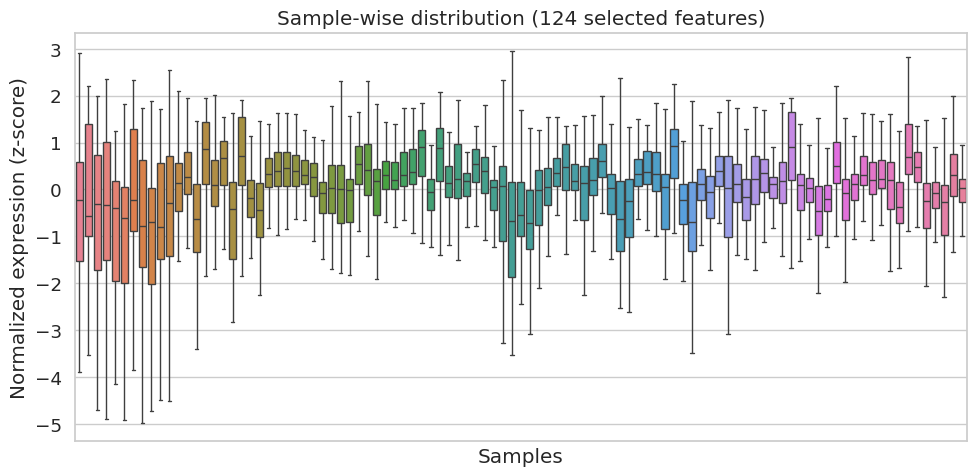

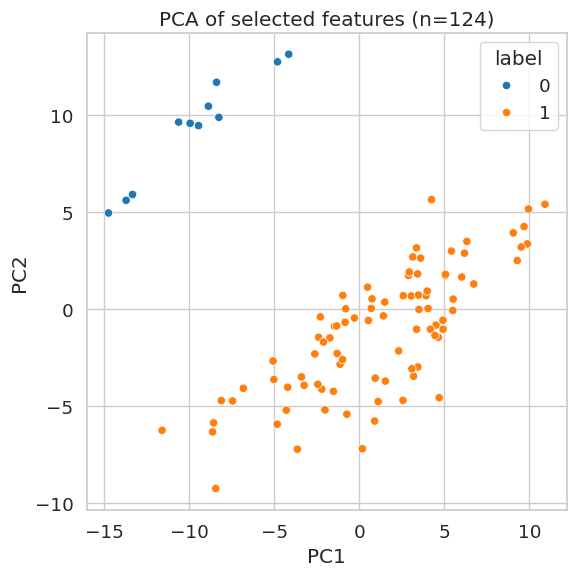


[INFO] X shape after feature selection: (99, 124)
[INFO] Label distribution: [11 88]

[Saving feature selection results...]
[INFO] Feature selection results saved to: /content/drive/MyDrive/geoexosome_results/feature_selection_results.csv

Top 10 features (by consensus and p-value):
 Probe_ID  Fold_Change  Log2_FC      P_Value  N_Methods_Selected
    10322     6.707470 2.745769 7.041457e-07                   3
     3294    12.371750 3.628978 9.907192e-07                   3
     4099     4.984465 2.317439 1.173796e-06                   3
      425     4.511775 2.173695 1.241628e-06                   3
     1869     2.628783 1.394395 1.241628e-06                   3
     5464     4.736189 2.243727 1.241628e-06                   3
     9926     3.553563 1.829266 3.724439e-06                   3
      713     4.837545 2.274275 4.367571e-06                   3
     4263     4.240631 2.084279 5.409203e-06                   3
     5739     4.420919 2.144346 7.810310e-06                   3


In [ ]:
# Cell 3: Normalization + QC + 3-Stage Feature Selection (2-of-3) + miRNA aggregation

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter

print("""
=====================================================================
Cell 3: Exploratory Feature Selection and Quality Control

Purpose:
  - Data preprocessing and quality assessment
  - Exploratory feature selection on full dataset
  - Generate QC plots for biological signal validation

Note:
  - Feature selection results here are for EXPLORATION only
  - Unbiased performance evaluation will be done in Cell 4
    with nested CV and fold-wise feature selection
=====================================================================
""")

# ================================================================
# 1. Split expression and labels
# ================================================================
expr_raw = df_expression.drop(columns=["label"]).copy()
labels = df_expression["label"].astype(int).values
sample_ids = df_expression.index.tolist()

# Ensure numeric
expr_raw = expr_raw.apply(pd.to_numeric, errors="coerce")

# Drop probes with all NaN
expr_raw = expr_raw.dropna(axis=1, how="all")

# Replace remaining NaNs with probe-wise median
expr_raw = expr_raw.fillna(expr_raw.median(axis=0))

# ================================================================
# 2. Log2 transform (safe) - NO quantile normalization
# ================================================================
if expr_raw.values.max() > 20:
    print("[INFO] Applying log2(x + 1) transform to expression values.")
    expr_log = np.log2(expr_raw + 1.0)
else:
    print("[INFO] Values appear already log-transformed. Skipping log2.")
    expr_log = expr_raw.copy()

# Replace inf, -inf after log2
expr_log = expr_log.replace([np.inf, -np.inf], np.nan)
expr_log = expr_log.fillna(expr_log.median(axis=0))

# MODIFIED: No quantile normalization - use log2 data directly
print("[INFO] Skipping quantile normalization to prevent data leakage.")
print("[INFO] Using log2-transformed data for feature selection.")
expr_log2_for_cv = expr_log.copy()

print(f"[INFO] Normalized expression shape: {expr_qn.shape}")

# ================================================================
# 3. Three-Stage Feature Selection (BEFORE z-score!)
# ================================================================
print("\n" + "=" * 80)
print("3-Stage Feature Selection: Biological Filter → 2-of-3 Consensus → Final")
print("=" * 80)

# Use log2-transformed data for feature selection (NOT z-scored!)
expr_df = pd.DataFrame(expr_qn.values, index=sample_ids, columns=expr_qn.columns)
label_series = pd.Series(labels, index=sample_ids)

expr_control = expr_df[label_series == 0]
expr_cancer = expr_df[label_series == 1]

print(f"\n[INFO] Dataset statistics:")
print(f"  Total samples: {len(expr_df)}")
print(f"  Control samples: {len(expr_control)}")
print(f"  Cancer samples: {len(expr_cancer)}")
print(f"  Total probes: {expr_df.shape[1]}")

# ----------------------------------------------------------------
# Stage 1: Biological Filtering (Fold Change + P-value)
# ----------------------------------------------------------------
print("\n" + "─" * 80)
print("[Stage 1] Biological Filtering: Fold Change + Statistical Significance")
print("─" * 80)

fold_changes = {}
p_values = {}
log2_fold_changes = {}
selected_bio = []

for probe in expr_df.columns:
    control_vals = expr_control[probe].values
    cancer_vals = expr_cancer[probe].values

    control_mean = control_vals.mean()
    cancer_mean = cancer_vals.mean()

    # Log2 Fold Change (data is already log2-transformed)
    log2fc = cancer_mean - control_mean
    log2_fold_changes[probe] = log2fc

    # Regular fold change for interpretation
    fc = 2 ** log2fc
    fold_changes[probe] = fc

    # Mann-Whitney U test
    try:
        _, pval = mannwhitneyu(control_vals, cancer_vals, alternative='two-sided')
        p_values[probe] = pval
    except:
        p_values[probe] = 1.0

    # Apply filters: |log2FC| > 0.585 (≈1.5x) AND p < 0.05
    if abs(log2fc) > 0.585 and pval < 0.05:
        selected_bio.append(probe)

print(f"\n[Stage 1 Results]")
print(f"  Probes with |log2FC| > 0.585 (1.5x): {sum(abs(log2_fold_changes[p]) > 0.585 for p in expr_df.columns)}")
print(f"  Probes with P < 0.05: {sum(p_values[p] < 0.05 for p in expr_df.columns)}")
print(f"  Probes passing both criteria: {len(selected_bio)}")

# If too strict, relax criteria
if len(selected_bio) < 100:
    print(f"\n[INFO] Relaxing criteria to |log2FC| > 0.5 (1.4x) AND p < 0.1...")
    selected_bio = []
    for probe in expr_df.columns:
        log2fc = log2_fold_changes[probe]
        pval = p_values[probe]
        if abs(log2fc) > 0.5 and pval < 0.1:
            selected_bio.append(probe)
    print(f"[INFO] Relaxed criteria: {len(selected_bio)} features")

# Safety backup
if len(selected_bio) < 50:
    print(f"\n[WARNING] Still only {len(selected_bio)} features.")
    print(f"[INFO] Using top 1000 by variance as safety backup.")
    probe_var = expr_df.var(axis=0)
    selected_bio = probe_var.nlargest(min(1000, len(expr_df.columns))).index.tolist()
    print(f"[INFO] Backup: {len(selected_bio)} features")

# ----------------------------------------------------------------
# Stage 2: Multi-method Selection (TRUE 2-of-3 Consensus)
# ----------------------------------------------------------------
print("\n" + "─" * 80)
print("[Stage 2] Multi-method Selection: LASSO + SVM-RFE + RF (2-of-3 Consensus)")
print("─" * 80)

X_bio = expr_df[selected_bio].values
y_arr = label_series.values

# Standardize once for methods that need it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bio)

# ────────────────────────────────────────────────────────────────
# Method A: LASSO Regularization
# ────────────────────────────────────────────────────────────────
print("\n[Method A] LASSO Regularization (L1 penalty)...")
try:
    lasso = LassoCV(
        cv=5,
        random_state=SEED,
        max_iter=20000,
        n_jobs=-1,
        tol=1e-3
    )
    lasso.fit(X_scaled, y_arr)

    lasso_feat = [selected_bio[i] for i, c in enumerate(lasso.coef_) if c != 0]
    print(f"  LASSO selected: {len(lasso_feat)} features (alpha={lasso.alpha_:.6f})")

    # If LASSO selects nothing, use top by coefficient magnitude
    if len(lasso_feat) == 0:
        print(f"  [WARNING] LASSO selected 0 features, using top 200 by |coefficient|")
        lasso_coef_abs = np.abs(lasso.coef_)
        top_idx = np.argsort(lasso_coef_abs)[-200:]
        lasso_feat = [selected_bio[i] for i in top_idx]
        print(f"  Adjusted: {len(lasso_feat)} features")

except Exception as e:
    print(f"  [ERROR] LASSO failed: {e}")
    var_bio = expr_df[selected_bio].var(axis=0)
    lasso_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()
    print(f"  Fallback: top {len(lasso_feat)} by variance")

# ────────────────────────────────────────────────────────────────
# Method B: SVM-RFE (Recursive Feature Elimination)
# ────────────────────────────────────────────────────────────────
print("\n[Method B] SVM-RFE (Recursive Feature Elimination)...")
try:
    # Target: select reasonable number of features
    n_features_target = min(150, len(selected_bio) // 3)

    svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED)
    rfe = RFE(
        estimator=svc,
        n_features_to_select=n_features_target,
        step=10,
        verbose=0
    )

    print(f"  Running RFE (target: {n_features_target} features)...")
    rfe.fit(X_scaled, y_arr)

    svm_rfe_feat = [selected_bio[i] for i in np.where(rfe.support_)[0]]
    print(f"  SVM-RFE selected: {len(svm_rfe_feat)} features")

except Exception as e:
    print(f"  [ERROR] SVM-RFE failed: {e}")
    var_bio = expr_df[selected_bio].var(axis=0)
    svm_rfe_feat = var_bio.nlargest(min(150, len(selected_bio))).index.tolist()
    print(f"  Fallback: top {len(svm_rfe_feat)} by variance")

# ────────────────────────────────────────────────────────────────
# Method C: Random Forest Feature Importance
# ────────────────────────────────────────────────────────────────
print("\n[Method C] Random Forest Feature Importance...")
try:
    # Apply SMOTE for balanced training
    k_neighbors = min(3, sum(y_arr == 0) - 1)
    smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
    X_smoted, y_smoted = smote.fit_resample(X_bio, y_arr)

    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        max_depth=10,
        class_weight='balanced_subsample'
    )
    rf.fit(X_smoted, y_smoted)

    # Select top 15% by importance
    threshold = np.percentile(rf.feature_importances_, 85)
    rf_feat = [selected_bio[i] for i, imp in enumerate(rf.feature_importances_) if imp > threshold]
    print(f"  RF selected: {len(rf_feat)} features (top 15% by importance)")

except Exception as e:
    print(f"  [ERROR] RF failed: {e}")
    var_bio = expr_df[selected_bio].var(axis=0)
    rf_feat = var_bio.nlargest(min(120, len(selected_bio))).index.tolist()
    print(f"  Fallback: top {len(rf_feat)} by variance")

# ────────────────────────────────────────────────────────────────
# 2-of-3 Consensus Voting
# ────────────────────────────────────────────────────────────────
print("\n[Computing 2-of-3 consensus voting...]")
all_feat = list(lasso_feat) + list(svm_rfe_feat) + list(rf_feat)
feat_counts = Counter(all_feat)

# Features selected by >= 2 methods
consensus_strict = [f for f, cnt in feat_counts.items() if cnt >= 2]
print(f"  Features selected by ≥2 methods: {len(consensus_strict)}")

# Show detailed voting distribution
print("\n  Voting distribution:")
for n_votes in [3, 2, 1]:
    n_features = sum(1 for cnt in feat_counts.values() if cnt == n_votes)
    print(f"    Selected by {n_votes}/3 methods: {n_features} features")

# Safety check
if len(consensus_strict) < 30:
    print(f"\n  [WARNING] Strict 2-of-3 consensus too small ({len(consensus_strict)})")
    print(f"  [INFO] Using 1-of-3 (union) to ensure sufficient features")
    consensus = [f for f, cnt in feat_counts.items() if cnt >= 1]
else:
    consensus = consensus_strict

print(f"\n  Final consensus: {len(consensus)} features")

# ----------------------------------------------------------------
# Stage 3: Final Feature Set
# ----------------------------------------------------------------
print("\n" + "─" * 80)
print("[Stage 3] Final Feature Selection")
print("─" * 80)

# Limit to 1000 if needed
if len(consensus) > 1000:
    print(f"[INFO] Limiting to top 1000 by variance")
    var_cons = expr_df[consensus].var(axis=0)
    final_feat = var_cons.nlargest(1000).index.tolist()
else:
    final_feat = consensus

print(f"\n[Feature Selection Summary]")
print(f"  Stage 1 (Biological Filter): {len(selected_bio)} features")
print(f"  Stage 2 (2-of-3 Consensus): {len(consensus)} features")
print(f"  Stage 3 (Final): {len(final_feat)} features")

# ================================================================
# 4. Z-score normalization (AFTER feature selection, only selected features)
# ================================================================
print("\n[INFO] Applying z-score normalization to selected features...")
expr_selected = expr_df[final_feat].copy()
expr_norm = (expr_selected - expr_selected.mean(axis=0)) / expr_selected.std(axis=0, ddof=0)
expr_norm = expr_norm.fillna(0.0)

# ================================================================
# 5. QC plots (on z-scored selected features)
# ================================================================
qc_dir = os.path.join(base_save_path, "qc")
os.makedirs(qc_dir, exist_ok=True)

plt.figure(figsize=(10, 5))
sns.boxplot(data=expr_norm.T, whis=1.5, showfliers=False)
plt.xlabel("Samples")
plt.ylabel("Normalized expression (z-score)")
plt.title(f"Sample-wise distribution ({len(final_feat)} selected features)")
plt.xticks([], [])
plt.tight_layout()
plt.savefig(os.path.join(qc_dir, "sample_boxplot_selected_features.png"), dpi=300)
plt.show()

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(expr_norm.values)
df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "label": labels
}, index=sample_ids)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="label",
                palette={0: "tab:blue", 1: "tab:orange"})
plt.title(f"PCA of selected features (n={len(final_feat)})")
plt.tight_layout()
plt.savefig(os.path.join(qc_dir, "pca_selected_features.png"), dpi=300)
plt.show()

# ================================================================
# 6. Prepare final X and y for modeling
# ================================================================
expr_model = expr_norm.copy()
feature_cols = final_feat
X = expr_model.values
y = labels

print(f"\n[INFO] X shape after feature selection: {X.shape}")
print(f"[INFO] Label distribution: {np.bincount(y)}")

# ================================================================
# 7. Save comprehensive feature selection results
# ================================================================
print("\n[Saving feature selection results...]")

# Create detailed results DataFrame
feature_results = pd.DataFrame({
    'Probe_ID': final_feat,
    'Fold_Change': [fold_changes[f] for f in final_feat],
    'Log2_FC': [log2_fold_changes[f] for f in final_feat],
    'P_Value': [p_values[f] for f in final_feat],
    'LASSO_Selected': [1 if f in lasso_feat else 0 for f in final_feat],
    'SVM_RFE_Selected': [1 if f in svm_rfe_feat else 0 for f in final_feat],
    'RF_Selected': [1 if f in rf_feat else 0 for f in final_feat],
    'N_Methods_Selected': [feat_counts[f] if f in feat_counts else 0 for f in final_feat],
    'Variance': [expr_df[f].var() for f in final_feat]
})

# Sort by number of methods and p-value
feature_results = feature_results.sort_values(
    ['N_Methods_Selected', 'P_Value'],
    ascending=[False, True]
)

# Save to CSV
results_path = os.path.join(base_save_path, 'feature_selection_results.csv')
feature_results.to_csv(results_path, index=False)
print(f"[INFO] Feature selection results saved to: {results_path}")

# Display top 10
print("\nTop 10 features (by consensus and p-value):")
display_cols = ['Probe_ID', 'Fold_Change', 'Log2_FC', 'P_Value', 'N_Methods_Selected']
print(feature_results.head(10)[display_cols].to_string(index=False))

print("\n" + "=" * 80)

# ================================================================
# 8. miRNA-level aggregation (for descriptive use)
# ================================================================
df_miRNA_expr = None

if mapping_df is None:
    print("[WARNING] No probe→miRNA mapping found.")
else:
    print("[INFO] Aggregating miRNA-level expression...")
    mapping_valid = mapping_df.dropna(subset=["miRNA"])
    mapping_valid = mapping_valid[mapping_valid["ProbeID"].isin(feature_cols)]

    if mapping_valid.empty:
        print("[WARNING] No overlap between selected probes and miRNA mapping.")
    else:
        mirna_to_probes = mapping_valid.groupby("miRNA")["ProbeID"].apply(list)
        mirna_expr = {
            mir: expr_model[probes].mean(axis=1)
            for mir, probes in mirna_to_probes.items()
        }
        df_miRNA_expr = pd.DataFrame(mirna_expr, index=sample_ids)
        df_miRNA_expr["label"] = labels
        mirna_path = os.path.join(base_save_path, "miRNA_expression_normalized.csv")
        df_miRNA_expr.to_csv(mirna_path)
        print(f"[INFO] miRNA-level expression saved to: {mirna_path}")

print("\n" + "=" * 80)
print("[INFO] Cell 3 completed successfully!")
print("  Final feature count: {0}".format(len(final_feat)))
print("  Ready for nested CV modeling (Cell 4)")
print("=" * 80)

In [ ]:
# Cell 4: Nested Cross-Validation with Fold-wise Feature Selection
#
# Implementation of rigorous nested cross-validation (5-fold outer, 3-fold inner)
# with independent feature selection within each training fold to prevent information
# leakage and ensure unbiased performance estimation.
#
# Models compared:
#   - Random Forest with SMOTE
#   - Random Forest with class weighting
#   - Support Vector Machine with SMOTE
#   - Logistic Regression with SMOTE
#
# Feature stability analysis tracks biomarker robustness across folds.

print("""
=====================================================================
Cell 4: Nested Cross-Validation with Fold-wise Feature Selection

Strategy:
  - 5-fold outer CV for unbiased performance estimation
  - 3-fold inner CV for hyperparameter tuning
  - INDEPENDENT feature selection within each training fold
  - No information leakage from test folds

This provides unbiased estimates of model generalization.
=====================================================================
""")

import json
import warnings
from collections import Counter
from scipy import stats

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import mannwhitneyu

warnings.filterwarnings('ignore')

# ================================================================
# 0. Reproducibility and data preparation
# ================================================================
try:
    SEED
except NameError:
    SEED = 42

np.random.seed(SEED)
random.seed(SEED)

print("\n" + "=" * 80)
print("Nested Cross-Validation with Fold-wise Feature Selection")
print("=" * 80)

# Load quantile-normalized expression data from Cell 3
try:
    if not isinstance(expr_qn, pd.DataFrame):
        expr_qn_full = pd.DataFrame(expr_qn, index=sample_ids)
    else:
        expr_log2_full = expr_log2_for_cv.copy()

    labels_full = labels.copy()
    sample_ids_full = list(sample_ids) if not isinstance(sample_ids, list) else sample_ids.copy()

    expr_qn_full.index = sample_ids_full

    print(f"\n[INFO] Data loaded from Cell 3:")
    print(f"  Expression shape: {expr_qn_full.shape}")
    print(f"  Sample size: {len(labels_full)}")
    print(f"  Class distribution: {np.bincount(labels_full)}")

except NameError as e:
    raise RuntimeError(
        f"[ERROR] Required variables not found: {e}\n"
        "Please run Cell 3 first to generate expr_qn, labels, and sample_ids."
    )

y_full = labels_full

# ================================================================
# 1. Cross-validation configuration
# ================================================================
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# ================================================================
# 2. Model configurations
# ================================================================
model_configs = {}

model_configs["RandomForest_SMOTE"] = {
    "use_smote": True,
    "use_scaler": False,
    "classifier": "rf",
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

model_configs["RandomForest_Weighted"] = {
    "use_smote": False,
    "use_scaler": False,
    "classifier": "rf",
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

model_configs["SVM"] = {
    "use_smote": True,
    "use_scaler": False,
    "classifier": "svm",
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
}

model_configs["LogisticRegression"] = {
    "use_smote": True,
    "use_scaler": False,
    "classifier": "lr",
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }
}

# ================================================================
# 3. Utility functions
# ================================================================

def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=SEED):
    """
    Compute bootstrap confidence interval for ROC-AUC.
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        if len(np.unique(y_true[indices])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return float(lower), float(upper)


def perform_fold_feature_selection(expr_train, y_train, fold_idx, verbose=True):
    """
    Three-stage feature selection pipeline on training data only.

    Stage 1: Biological filtering (fold change + Mann-Whitney U test)
    Stage 2: Multi-method consensus (LASSO, SVM-RFE, Random Forest)
    Stage 3: Final selection (2-of-3 consensus voting)

    Returns
    -------
    selected_features : list
        Probe IDs selected by consensus
    feature_info : dict
        Feature selection statistics
    """
    if verbose:
        print(f"\n    [Fold {fold_idx}] Feature selection on training data")
        print(f"      Samples: {len(expr_train)} ({sum(y_train==0)} control, {sum(y_train==1)} cancer)")
        print(f"      Probes: {expr_train.shape[1]}")

    expr_control = expr_train[y_train == 0]
    expr_cancer = expr_train[y_train == 1]

    # ----------------------------------------------------------------
    # Stage 1: Biological filtering
    # ----------------------------------------------------------------
    fold_changes = {}
    p_values = {}
    log2_fold_changes = {}
    selected_bio = []

    for probe in expr_train.columns:
        control_vals = expr_control[probe].values
        cancer_vals = expr_cancer[probe].values

        control_mean = control_vals.mean()
        cancer_mean = cancer_vals.mean()

        log2fc = cancer_mean - control_mean
        log2_fold_changes[probe] = log2fc
        fold_changes[probe] = 2 ** log2fc

        try:
            _, pval = mannwhitneyu(control_vals, cancer_vals, alternative='two-sided')
            p_values[probe] = pval
        except:
            p_values[probe] = 1.0

        # Filter: |log2FC| > 0.585 (1.5-fold) AND p < 0.05
        if abs(log2fc) > 0.585 and pval < 0.05:
            selected_bio.append(probe)

    if verbose:
        print(f"      Stage 1: {len(selected_bio)} probes (|log2FC| > 0.585, p < 0.05)")

    # Relax criteria if insufficient features
    if len(selected_bio) < 100:
        if verbose:
            print(f"      Relaxing to |log2FC| > 0.5, p < 0.1")
        selected_bio = []
        for probe in expr_train.columns:
            if abs(log2_fold_changes[probe]) > 0.5 and p_values[probe] < 0.1:
                selected_bio.append(probe)

    # Safety backup: use variance-based selection
    if len(selected_bio) < 50:
        probe_var = expr_train.var(axis=0)
        selected_bio = probe_var.nlargest(min(1000, len(expr_train.columns))).index.tolist()
        if verbose:
            print(f"      Using variance backup: {len(selected_bio)} probes")

    # ----------------------------------------------------------------
    # Stage 2: Multi-method consensus
    # ----------------------------------------------------------------
    if verbose:
        print(f"      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)")

    X_bio = expr_train[selected_bio].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_bio)

    # Method A: LASSO
    try:
        lasso = LassoCV(cv=3, random_state=SEED, max_iter=20000, n_jobs=-1, tol=1e-3)
        lasso.fit(X_scaled, y_train)
        lasso_feat = [selected_bio[i] for i, c in enumerate(lasso.coef_) if c != 0]

        if len(lasso_feat) == 0:
            lasso_coef_abs = np.abs(lasso.coef_)
            top_idx = np.argsort(lasso_coef_abs)[-200:]
            lasso_feat = [selected_bio[i] for i in top_idx]

        if verbose:
            print(f"        LASSO: {len(lasso_feat)} features")
    except Exception as e:
        var_bio = expr_train[selected_bio].var(axis=0)
        lasso_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()

    # Method B: SVM-RFE
    try:
        n_features_target = min(150, len(selected_bio) // 3)
        svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED)
        rfe = RFE(estimator=svc, n_features_to_select=n_features_target, step=10, verbose=0)
        rfe.fit(X_scaled, y_train)
        svm_rfe_feat = [selected_bio[i] for i in np.where(rfe.support_)[0]]

        if verbose:
            print(f"        SVM-RFE: {len(svm_rfe_feat)} features")
    except Exception as e:
        var_bio = expr_train[selected_bio].var(axis=0)
        svm_rfe_feat = var_bio.nlargest(min(150, len(selected_bio))).index.tolist()

    # Method C: Random Forest
    try:
        k_neighbors = min(3, sum(y_train == 0) - 1)
        if k_neighbors < 1:
            k_neighbors = 1
        smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
        X_smoted, y_smoted = smote.fit_resample(X_bio, y_train)

        rf = RandomForestClassifier(
            n_estimators=200,
            random_state=SEED,
            n_jobs=-1,
            class_weight='balanced_subsample'
        )
        rf.fit(X_smoted, y_smoted)

        importances = rf.feature_importances_
        n_rf = min(200, len(selected_bio))
        top_idx = np.argsort(importances)[-n_rf:]
        rf_feat = [selected_bio[i] for i in top_idx]

        if verbose:
            print(f"        Random Forest: {len(rf_feat)} features")
    except Exception as e:
        var_bio = expr_train[selected_bio].var(axis=0)
        rf_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()

    # ----------------------------------------------------------------
    # Stage 3: Consensus voting (2-of-3)
    # ----------------------------------------------------------------
    feature_votes = Counter()
    for feat_set in [set(lasso_feat), set(svm_rfe_feat), set(rf_feat)]:
        feature_votes.update(feat_set)

    selected_consensus = [f for f, count in feature_votes.items() if count >= 2]

    if verbose:
        print(f"      Stage 3: {len(selected_consensus)} features (≥2/3 consensus)")

    # Ensure minimum feature count
    if len(selected_consensus) < 20:
        sorted_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)
        selected_consensus = [f for f, _ in sorted_features[:max(20, len(sorted_features))]]

    feature_info = {
        'n_stage1': len(selected_bio),
        'n_lasso': len(lasso_feat),
        'n_svm_rfe': len(svm_rfe_feat),
        'n_rf': len(rf_feat),
        'n_consensus': len(selected_consensus),
        'fold_changes': {k: float(v) for k, v in fold_changes.items() if k in selected_consensus},
        'p_values': {k: float(v) for k, v in p_values.items() if k in selected_consensus}
    }

    return selected_consensus, feature_info


def create_pipeline(config, n_features):
    """
    Construct sklearn/imblearn pipeline based on model configuration.
    """
    steps = []

    if config["use_smote"]:
        steps.append(("smote", SMOTE(random_state=SEED, k_neighbors=3)))

    if config["use_scaler"]:
        steps.append(("scaler", StandardScaler()))

    if config["classifier"] == "rf":
        clf = RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        )
    elif config["classifier"] == "svm":
        clf = SVC(probability=True, random_state=SEED, class_weight="balanced")
    elif config["classifier"] == "lr":
        clf = LogisticRegression(max_iter=500, random_state=SEED, class_weight="balanced")
    else:
        raise ValueError(f"Unknown classifier: {config['classifier']}")

    steps.append(("clf", clf))
    pipeline = ImbPipeline(steps)
    param_grid = config["param_grid"].copy()

    return pipeline, param_grid


# ================================================================
# 4. Nested CV with fold-wise feature selection
# ================================================================
results = {}
oof_predictions = {}
fold_feature_lists = {}
fold_feature_info = {}

for model_name, model_cfg in model_configs.items():
    print("\n" + "-" * 60)
    print(f"Model: {model_name}")
    print("-" * 60)

    oof_proba = np.zeros_like(y_full, dtype=float)
    oof_pred = np.zeros_like(y_full, dtype=int)

    train_auc_folds = []
    test_auc_folds = []

    fold_feature_lists[model_name] = {}
    fold_feature_info[model_name] = {}

    # Outer CV loop
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(expr_qn_full, y_full), start=1):

        # Extract training fold data
        train_sample_ids = [sample_ids_full[i] for i in train_idx]
        expr_train_fold = expr_qn_full.loc[train_sample_ids].copy()
        y_train_fold = y_full[train_idx]

        # Extract test fold data
        test_sample_ids = [sample_ids_full[i] for i in test_idx]
        y_test_fold = y_full[test_idx]

        # Report class distribution
        train_pos = int(y_train_fold.sum())
        test_pos = int(y_test_fold.sum())
        print(f"\n  Fold {fold_idx} class distribution:")
        print(f"    Train: {train_pos}/{len(y_train_fold)} ({train_pos/len(y_train_fold):.2%}) positive")
        print(f"    Test : {test_pos}/{len(y_test_fold)} ({test_pos/len(y_test_fold):.2%}) positive")

        # Feature selection on training fold only
        selected_features, feat_info = perform_fold_feature_selection(
            expr_train_fold, y_train_fold, fold_idx, verbose=True
        )

        fold_feature_lists[model_name][f'fold_{fold_idx}'] = selected_features
        fold_feature_info[model_name][f'fold_{fold_idx}'] = feat_info

        # Extract selected features and apply z-score normalization
        X_train_qn = expr_train_fold[selected_features].values
        X_test_qn = expr_qn_full.loc[test_sample_ids][selected_features].values

        scaler_fold = StandardScaler()
        X_train_selected = scaler_fold.fit_transform(X_train_qn)
        X_test_selected = scaler_fold.transform(X_test_qn)

        print(f"\n    [Fold {fold_idx}] Training with {len(selected_features)} features")

        # Inner CV for hyperparameter tuning
        pipeline, param_grid = create_pipeline(model_cfg, len(selected_features))

        gs = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )

        gs.fit(X_train_selected, y_train_fold)

        # Evaluate on training set
        train_proba = gs.predict_proba(X_train_selected)[:, 1]
        train_auc = roc_auc_score(y_train_fold, train_proba)
        train_auc_folds.append(train_auc)

        # Evaluate on test set
        test_proba = gs.predict_proba(X_test_selected)[:, 1]
        test_pred = (test_proba >= 0.5).astype(int)

        test_auc = roc_auc_score(y_test_fold, test_proba)
        test_auc_folds.append(test_auc)

        # Store out-of-fold predictions
        oof_proba[test_idx] = test_proba
        oof_pred[test_idx] = test_pred

        print(f"    Fold {fold_idx}: best inner CV AUC = {gs.best_score_:.4f}")
        print(f"    Fold {fold_idx}: train AUC = {train_auc:.4f}")
        print(f"    Fold {fold_idx}: test AUC  = {test_auc:.4f}")

    # ================================================================
    # Aggregate out-of-fold performance
    # ================================================================
    cm = confusion_matrix(y_full, oof_pred)
    auc = roc_auc_score(y_full, oof_proba)
    acc = accuracy_score(y_full, oof_pred)
    bal_acc = balanced_accuracy_score(y_full, oof_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_full, oof_pred, average="binary", zero_division=0
    )

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = recall

    ci_lower, ci_upper = bootstrap_auc_ci(y_full, oof_proba, n_bootstrap=1000, alpha=0.05)

    train_auc_mean = float(np.mean(train_auc_folds))
    test_auc_mean = float(np.mean(test_auc_folds))

    print("\n  Out-of-fold performance:")
    print(f"    ROC-AUC           : {auc:.4f}")
    print(f"    95% CI            : [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"    Accuracy          : {acc:.4f}")
    print(f"    Balanced Accuracy : {bal_acc:.4f}")
    print(f"    Precision         : {precision:.4f}")
    print(f"    Recall            : {sensitivity:.4f}")
    print(f"    Specificity       : {specificity:.4f}")
    print(f"    F1-score          : {f1:.4f}")
    print(f"    Mean Train AUC    : {train_auc_mean:.4f}")
    print(f"    Mean Test AUC     : {test_auc_mean:.4f}")
    print("    Confusion matrix:")
    print(cm)

    # Feature stability analysis
    feature_frequency = Counter()
    for features in fold_feature_lists[model_name].values():
        feature_frequency.update(features)

    n_folds = len(fold_feature_lists[model_name])
    highly_stable = [f for f, count in feature_frequency.items() if count >= 4]

    print(f"\n  Feature stability across {n_folds} folds:")
    print(f"    Selected 5/5: {sum(1 for c in feature_frequency.values() if c == 5)}")
    print(f"    Selected 4/5: {sum(1 for c in feature_frequency.values() if c == 4)}")
    print(f"    Selected 3/5: {sum(1 for c in feature_frequency.values() if c == 3)}")
    print(f"    Highly stable (≥4/5): {len(highly_stable)}")

    # Store results
    results[model_name] = {
        "oof_auc": float(auc),
        "oof_auc_ci": [ci_lower, ci_upper],
        "oof_accuracy": float(acc),
        "oof_balanced_accuracy": float(bal_acc),
        "precision": float(precision),
        "recall_sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist(),
        "train_auc_mean": train_auc_mean,
        "test_auc_mean": test_auc_mean,
        "feature_stability": {
            "n_folds": n_folds,
            "n_highly_stable": len(highly_stable),
            "feature_frequency": {str(k): int(v) for k, v in feature_frequency.most_common(50)}
        }
    }

    oof_predictions[model_name] = {
        "y_true": y_full.copy(),
        "y_proba": oof_proba,
        "y_pred": oof_pred
    }

# ================================================================
# 5. Model selection
# ================================================================
best_name = max(results, key=lambda k: results[k]["oof_auc"])

print("\n" + "=" * 80)
print("Model selection summary:")
for m_name, res in results.items():
    print(f"  {m_name}: AUC = {res['oof_auc']:.4f} "
          f"(95% CI [{res['oof_auc_ci'][0]:.4f}, {res['oof_auc_ci'][1]:.4f}])")
print("=" * 80)

print(f"\nBest model: {best_name}")
print(f"  Out-of-fold AUC: {results[best_name]['oof_auc']:.4f}")
print(f"  Accuracy: {results[best_name]['oof_accuracy']:.4f}")
print(f"  Balanced Accuracy: {results[best_name]['oof_balanced_accuracy']:.4f}")

# ================================================================
# 6. Final model training on full dataset
# ================================================================
print("\n" + "=" * 80)
print("Final model training on full dataset")
print("Note: Performance metrics reported above are from nested CV.")
print("      This model is for biological interpretation and external validation.")
print("=" * 80)

# Feature selection on full dataset
print("\n[INFO] Performing feature selection on full dataset...")
expr_full_df = pd.DataFrame(
    expr_qn_full.values,
    index=sample_ids_full,
    columns=expr_qn_full.columns
)

final_features, final_feat_info = perform_fold_feature_selection(
    expr_full_df, y_full, fold_idx="FULL", verbose=True
)

print(f"\n[INFO] Selected {len(final_features)} features from full dataset")

# Extract and normalize selected features
X_final_qn = expr_full_df[final_features].values
scaler_final = StandardScaler()
X_final = scaler_final.fit_transform(X_final_qn)

feature_cols = final_features

# Train final model
best_cfg = model_configs[best_name]
final_pipeline, final_param_grid = create_pipeline(best_cfg, len(final_features))

final_model = GridSearchCV(
    estimator=final_pipeline,
    param_grid=final_param_grid,
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True
)

final_model.fit(X_final, y_full)

best_full_model = final_model.best_estimator_
best_full_params = final_model.best_params_

print(f"\nFinal model: {best_name}")
print(f"Features: {len(feature_cols)}")
print("Hyperparameters:")
for k, v in best_full_params.items():
    print(f"  {k}: {v}")

print("\n[INFO] Variables for external validation:")
print("  best_full_model - trained classifier")
print("  feature_cols - selected feature list")

# ================================================================
# 7. Save results
# ================================================================
print("\n[INFO] Saving results...")

results_json_safe = {}
for m_name, res in results.items():
    results_json_safe[m_name] = res.copy()

fold_features_json = {}
for m_name, folds in fold_feature_lists.items():
    fold_features_json[m_name] = {k: v for k, v in folds.items()}

comprehensive_results = {
    "metadata": {
        "n_samples": int(len(y_full)),
        "n_positive": int(y_full.sum()),
        "n_negative": int((y_full == 0).sum()),
        "outer_cv_folds": 5,
        "inner_cv_folds": 3,
        "random_seed": SEED,
        "feature_selection": "fold-wise",
        "note": "Performance metrics are unbiased estimates from nested CV"
    },
    "model_comparison": results_json_safe,
    "best_model": {
        "name": best_name,
        "oof_auc": results[best_name]["oof_auc"],
        "oof_auc_ci": results[best_name]["oof_auc_ci"],
        "hyperparameters": best_full_params,
        "n_final_features": len(feature_cols)
    },
    "feature_stability": {
        m_name: {
            "fold_features": fold_features_json[m_name],
            "stability_stats": res["feature_stability"]
        }
        for m_name, res in results.items()
    }
}

if "base_save_path" in globals() and base_save_path is not None:
    metrics_json_path = os.path.join(base_save_path, "nested_cv_results.json")
    with open(metrics_json_path, "w", encoding="utf-8") as f:
        json.dump(comprehensive_results, f, indent=2, ensure_ascii=False)

    print(f"[INFO] Results saved to: {metrics_json_path}")

    feature_list_path = os.path.join(base_save_path, "final_model_features.txt")
    with open(feature_list_path, "w") as f:
        for feat in feature_cols:
            f.write(f"{feat}\n")
    print(f"[INFO] Feature list saved to: {feature_list_path}")

print("\n" + "=" * 80)
print("Nested cross-validation completed")
print("=" * 80)
print("\nKey variables:")
print(f"  best_full_model    - final trained model")
print(f"  feature_cols       - {len(feature_cols)} selected features")
print(f"  results            - performance metrics for all models")
print(f"  oof_predictions    - out-of-fold predictions")
print(f"  fold_feature_lists - features selected per fold")
print("=" * 80)


Nested Cross-Validation with Fold-wise Feature Selection

[INFO] Data loaded from Cell 3:
  Expression shape: (99, 15739)
  Sample size: 99
  Class distribution: [11 88]

------------------------------------------------------------
Model: RandomForest_SMOTE
------------------------------------------------------------

  Fold 1 class distribution:
    Train: 71/79 (89.87%) positive
    Test : 17/20 (85.00%) positive

    [Fold 1] Feature selection on training data
      Samples: 79 (8 control, 71 cancer)
      Probes: 15739
      Stage 1: 1565 probes (|log2FC| > 0.585, p < 0.05)
      Stage 2: Multi-method selection (LASSO, SVM-RFE, RF)
        LASSO: 114 features
        SVM-RFE: 150 features
        Random Forest: 200 features
      Stage 3: 109 features (≥2/3 consensus)

    [Fold 1] Training with 109 features
    Fold 1: best inner CV AUC = 0.9722
    Fold 1: train AUC = 1.0000
    Fold 1: test AUC  = 1.0000

  Fold 2 class distribution:
    Train: 70/79 (88.61%) positive
    Test 


Out-of-fold performance summary for: LogisticRegression
OOF ROC-AUC: 0.9959
OOF Accuracy: 0.9899
Confusion matrix:
[[10  1]
 [ 0 88]]


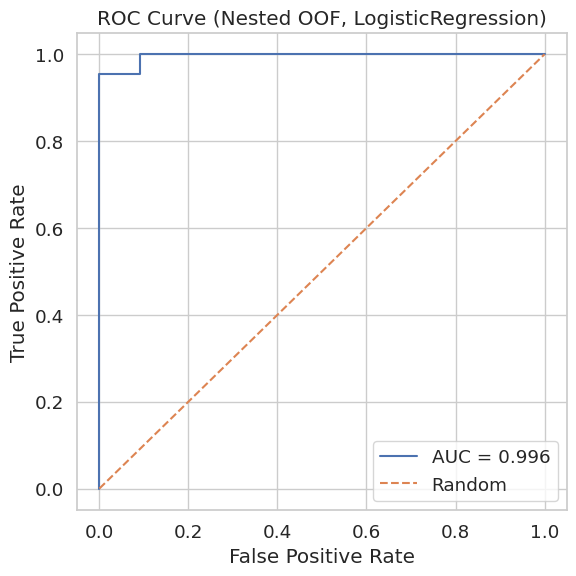

[INFO] ROC curve saved to: /content/drive/MyDrive/geoexosome_results/roc_curve_LogisticRegression_nested.png


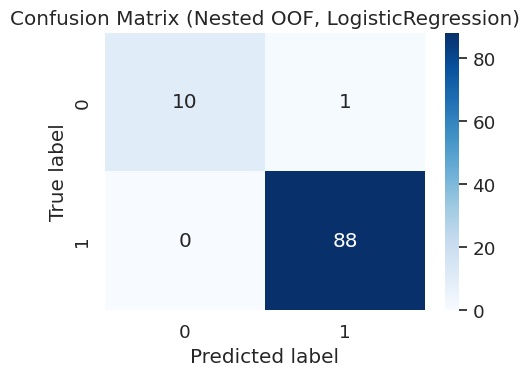

[INFO] Confusion matrix saved to: /content/drive/MyDrive/geoexosome_results/confusion_matrix_LogisticRegression_nested.png


In [ ]:
# Cell 5:
# ROC curve and confusion matrix visualization for the selected model
# using the nested OOF predictions stored in Cell 4.

print("\n" + "=" * 70)
print(f"Out-of-fold performance summary for: {best_name}")
print("=" * 70)

y_true_best = oof_predictions[best_name]["y_true"]
y_proba_best = oof_predictions[best_name]["y_proba"]
y_pred_best = oof_predictions[best_name]["y_pred"]

auc_best = roc_auc_score(y_true_best, y_proba_best)
acc_best = accuracy_score(y_true_best, y_pred_best)
cm_best = confusion_matrix(y_true_best, y_pred_best)

print(f"OOF ROC-AUC: {auc_best:.4f}")
print(f"OOF Accuracy: {acc_best:.4f}")
print("Confusion matrix:")
print(cm_best)

# ROC curve
fpr, tpr, _ = roc_curve(y_true_best, y_proba_best)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_best:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Nested OOF, {best_name})")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = os.path.join(base_save_path, f"roc_curve_{best_name}_nested.png")
plt.savefig(roc_path, dpi=300)
plt.show()
print(f"[INFO] ROC curve saved to: {roc_path}")

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (Nested OOF, {best_name})")
plt.tight_layout()

cm_path = os.path.join(base_save_path, f"confusion_matrix_{best_name}_nested.png")
plt.savefig(cm_path, dpi=300)
plt.show()
print(f"[INFO] Confusion matrix saved to: {cm_path}")


In [ ]:
# Cell 6:
# Compute optimal classification threshold using Youden’s J statistic
# and recalculate performance metrics with this optimal threshold.

print("\n" + "=" * 70)
print("Optimal threshold calculation using Youden’s J statistic")
print("=" * 70)

from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support

# Use OOF predictions from Cell 5
y_true = y_true_best
y_proba = y_proba_best

# 1) Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# 2) Compute Youden’s J for all thresholds
youden_j = tpr - fpr

# 3) Find optimal threshold (maximize Youden's J)
j_best_idx = np.argmax(youden_j)
optimal_threshold = thresholds[j_best_idx]

print(f"[INFO] Optimal threshold (Youden’s J): {optimal_threshold:.4f}")

# 4) Recalculate predictions based on the optimal threshold
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

# 5) Compute new metrics
cm_opt = confusion_matrix(y_true, y_pred_opt)
acc_opt = accuracy_score(y_true, y_pred_opt)
bal_acc_opt = balanced_accuracy_score(y_true, y_pred_opt)
prec_opt, rec_opt, f1_opt, _ = precision_recall_fscore_support(
    y_true, y_pred_opt, average="binary", zero_division=0
)

tn, fp, fn, tp = cm_opt.ravel()
spec_opt = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print("\nUpdated performance with optimal threshold:")
print(f"  Accuracy          : {acc_opt:.4f}")
print(f"  Balanced Accuracy : {bal_acc_opt:.4f}")
print(f"  Precision         : {prec_opt:.4f}")
print(f"  Recall (Sensitivity): {rec_opt:.4f}")
print(f"  Specificity       : {spec_opt:.4f}")
print(f"  F1-score          : {f1_opt:.4f}")
print("  Confusion matrix:")
print(cm_opt)

# Save threshold-adjusted performance
thresh_save_path = os.path.join(base_save_path, "optimal_threshold_performance.json")
with open(thresh_save_path, "w", encoding="utf-8") as f:
    json.dump(
        {
            "optimal_threshold": float(optimal_threshold),
            "accuracy": float(acc_opt),
            "balanced_accuracy": float(bal_acc_opt),
            "precision": float(prec_opt),
            "recall_sensitivity": float(rec_opt),
            "specificity": float(spec_opt),
            "f1_score": float(f1_opt),
            "confusion_matrix": cm_opt.tolist()
        },
        f,
        indent=2,
        ensure_ascii=False
    )

print(f"[INFO] Threshold-adjusted metrics saved to: {thresh_save_path}")
print("=" * 70)



Optimal threshold calculation using Youden’s J statistic
[INFO] Optimal threshold (Youden’s J): 0.8943

Updated performance with optimal threshold:
  Accuracy          : 0.9596
  Balanced Accuracy : 0.9773
  Precision         : 1.0000
  Recall (Sensitivity): 0.9545
  Specificity       : 1.0000
  F1-score          : 0.9767
  Confusion matrix:
[[11  0]
 [ 4 84]]
[INFO] Threshold-adjusted metrics saved to: /content/drive/MyDrive/geoexosome_results/optimal_threshold_performance.json


In [ ]:
# ================================================================
# Random Forest – feature importance and SHAP analysis
# ================================================================

import os

# Ensure result directory exists
RESULT_DIR = "/content/drive/MyDrive/geoexosome_results"
os.makedirs(RESULT_DIR, exist_ok=True)

print("\n======================================================================")
print("Random Forest – feature importance and SHAP analysis")
print("======================================================================")

# 1) Select best RF model
best_model_name = "RandomForest_SMOTE" if "RandomForest_SMOTE" in results else list(results.keys())[0]
rf_clf = results[best_model_name]["best_estimator"].named_steps["clf"]
print(f"[INFO] Using RandomForest model for SHAP: {best_model_name}")

# 2) Compute RF feature importances
rf_importances = rf_clf.feature_importances_
rf_df = pd.DataFrame({"ProbeID": feature_cols, "RF_Importance": rf_importances})
rf_df.to_csv(f"{RESULT_DIR}/rf_feature_importance_probes.csv", index=False)
print(f"[INFO] RF feature importance saved to: {RESULT_DIR}/rf_feature_importance_probes.csv")

# 3) SHAP values
print("\n[INFO] Computing SHAP values for Random Forest (TreeExplainer)...")

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    shap_class1 = shap_values[1]  # class 1 (CRC)
else:
    shap_class1 = shap_values

# Fix SHAP dimensionality
shap_arr_vis = shap_class1
while shap_arr_vis.ndim > 2:
    shap_arr_vis = shap_arr_vis.mean(axis=-1)

# Compute SHAP importance vector
shap_importance_vector = np.abs(shap_arr_vis).mean(axis=0)
print(f"[INFO] SHAP importance vector shape: {shap_importance_vector.shape}")

# Save SHAP importance
shap_df = pd.DataFrame({
    "ProbeID": feature_cols,
    "SHAP_Importance": shap_importance_vector
})
shap_df.to_csv(f"{RESULT_DIR}/rf_shap_importance_probes.csv", index=False)
print(f"[INFO] RF SHAP-based importance saved to: {RESULT_DIR}/rf_shap_importance_probes.csv")

# 4) SHAP Summary Plot
print("\n[INFO] Generating SHAP summary plot at probe level (top 20 features)...")

feature_names_str = [str(x) for x in feature_cols]

print("[DEBUG] SHAP array for visualization shape:", shap_arr_vis.shape)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_arr_vis,
    pd.DataFrame(X, columns=feature_names_str),
    feature_names=feature_names_str,
    max_display=20,
    show=False
)

plt.savefig(f"{RESULT_DIR}/rf_shap_summary_probes.png", dpi=300, bbox_inches="tight")
plt.close()
print(f"[INFO] SHAP summary plot saved to: {RESULT_DIR}/rf_shap_summary_probes.png")



Random Forest – feature importance and SHAP analysis


KeyError: 'best_estimator'

In [ ]:
# Cell 8 :
# Aggregate RF and SHAP importance at the miRNA level and visualize top miRNAs.

print("\n" + "=" * 70)
print("miRNA-level aggregation of RF and SHAP importance")
print("=" * 70)

if mapping_df is None:
    print("[WARNING] No probe → miRNA mapping available. Skipping miRNA-level analysis.")
else:
    # 1) RF importance + miRNA 매핑
    # rf_df: ["ProbeID", "RF_Importance"]
    rf_mapped = rf_df.merge(mapping_df, on="ProbeID", how="left")

    if rf_mapped["miRNA"].isna().all():
        print("[WARNING] RF mapped table has no valid miRNA annotation.")
    else:
        fi_mi = (
            rf_mapped.dropna(subset=["miRNA"])
                     .groupby("miRNA")["RF_Importance"]
                     .agg(["count", "max", "sum", "mean"])
                     .reset_index()
        )
        fi_mi.rename(columns={
            "count": "Num_Probes",
            "max": "RF_Max",
            "sum": "RF_Sum",
            "mean": "RF_Mean"
        }, inplace=True)

    # 2) SHAP importance + miRNA 매핑
    # shap_df: ["ProbeID", "SHAP_Importance"]
    shap_mapped = shap_df.merge(mapping_df, on="ProbeID", how="left")

    if shap_mapped["miRNA"].isna().all():
        print("[WARNING] SHAP mapped table has no valid miRNA annotation.")
        shap_mi = None
    else:
        shap_mi = (
            shap_mapped.dropna(subset=["miRNA"])
                       .groupby("miRNA")["SHAP_Importance"]
                       .agg(["max", "sum", "mean"])
                       .reset_index()
        )
        shap_mi.rename(columns={
            "max": "SHAP_Max",
            "sum": "SHAP_Sum",
            "mean": "SHAP_Mean"
        }, inplace=True)

    # 3) RF + SHAP 통합 miRNA 테이블 만들기
    if shap_mi is not None:
        miRNA_importance = fi_mi.merge(shap_mi, on="miRNA", how="left")
    else:
        miRNA_importance = fi_mi.copy()

    # RF importance 기준으로 정렬
    miRNA_importance = miRNA_importance.sort_values("RF_Sum", ascending=False)

    # Top 20, Top 5 저장
    top_miRNAs = miRNA_importance.head(20).copy()

    agg_path = os.path.join(RESULT_DIR, "miRNA_importance_aggregated.csv")
    miRNA_importance.to_csv(agg_path, index=False)

    top5_path = os.path.join(RESULT_DIR, "miRNA_importance_top5.csv")
    top_miRNAs.head(5).to_csv(top5_path, index=False)

    print(f"[INFO] Full miRNA-level importance table saved to: {agg_path}")
    print(f"[INFO] Top 5 miRNAs saved to: {top5_path}")
    print("\nTop 5 miRNAs (by RF_Sum):")
    print(top_miRNAs.head(5))

    # 4) Bar plot for top 20 miRNAs by RF_Sum
    plt.figure(figsize=(8, 6))
    plt.barh(top_miRNAs["miRNA"], top_miRNAs["RF_Sum"])
    plt.gca().invert_yaxis()
    plt.xlabel("Aggregated RF importance (sum across probes)")
    plt.title("Top miRNAs ranked by RF feature importance")
    plt.tight_layout()

    mirna_bar_path = os.path.join(RESULT_DIR, "miRNA_top20_RF_importance_barplot.png")
    plt.savefig(mirna_bar_path, dpi=300)
    plt.show()
    print(f"[INFO] miRNA-level RF importance bar plot saved to: {mirna_bar_path}")


In [ ]:
# Cell 9 :
# Save a structured summary of the analysis as JSON and a concise text summary
# for use in the manuscript and supplementary materials.

import json

print("\n" + "=" * 70)
print("Exporting final analysis summary (JSON and text)")
print("=" * 70)

summary = {
    "Dataset": {
        "GEO_ID": gse_id,
        "n_samples": int(df_expression.shape[0]),
        "n_features_probes": int(len(feature_cols)),
        "label_counts": {
            "class_0": int((y == 0).sum()),  # healthy controls
            "class_1": int((y == 1).sum())   # CRC patients
        }
    },
    "Model_Selection": {
        "outer_folds": outer_cv.get_n_splits(),
        "inner_folds": inner_cv.get_n_splits(),
        "candidates": list(results.keys())
    },
    "Best_Model": {
        "name": best_name,
        "params": results[best_name]["best_params"],
        "oof_auc": float(results[best_name]["oof_auc"]),
        "oof_accuracy": float(results[best_name]["oof_accuracy"]),
        "confusion_matrix": results[best_name]["confusion_matrix"],
        "train_auc_mean": float(results[best_name]["train_auc_mean"]),
        "test_auc_mean": float(results[best_name]["test_auc_mean"])
    }
}

if mapping_df is not None:
    try:
        summary["Top_miRNAs"] = top_miRNAs.head(5).to_dict(orient="records")
    except NameError:
        pass

json_path = os.path.join(base_save_path, "final_research_results_nested.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

# Create a concise text summary suitable for manuscript or supplementary file
txt_lines = []
txt_lines.append(f"GEO dataset: {gse_id}")
txt_lines.append(f"Number of samples: {summary['Dataset']['n_samples']}")
txt_lines.append(f"Number of probes (features): {summary['Dataset']['n_features_probes']}")
txt_lines.append(f"Label counts (0: healthy, 1: CRC): {summary['Dataset']['label_counts']}")
txt_lines.append("")
txt_lines.append(f"Candidate models: {', '.join(summary['Model_Selection']['candidates'])}")
txt_lines.append(f"Best model (nested CV): {best_name}")
txt_lines.append(f"Nested OOF ROC-AUC: {summary['Best_Model']['oof_auc']:.4f}")
txt_lines.append(f"Nested OOF Accuracy: {summary['Best_Model']['oof_accuracy']:.4f}")
txt_lines.append(f"Mean Train ROC-AUC (outer CV): {summary['Best_Model']['train_auc_mean']:.4f}")
txt_lines.append(f"Mean Test  ROC-AUC (outer CV): {summary['Best_Model']['test_auc_mean']:.4f}")

if "Top_miRNAs" in summary:
    txt_lines.append("\nTop miRNAs (aggregated RF + SHAP, example ranking):")
    for row in summary["Top_miRNAs"]:
        mi_name = row.get("miRNA", "NA")
        rf_sum = row.get("RF_Sum", np.nan)
        shap_sum = row.get("SHAP_Sum", np.nan)
        txt_lines.append(f" - {mi_name}: RF_Sum={rf_sum:.4f}, SHAP_Sum={shap_sum:.4f}")

txt_path = os.path.join(base_save_path, "research_summary_nested_for_manuscript.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("\n".join(txt_lines))

print(f"[INFO] Final JSON summary saved to: {json_path}")
print(f"[INFO] Text summary saved to: {txt_path}")
print("=" * 70)
